In [118]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [119]:
img = sitk.ReadImage(r"data\1.3.6.1.4.132274.66598776.77819905820063.1301827053.3.2_image.nii.gz", sitk.sitkFloat32)
lbl = sitk.ReadImage(r"data\1.3.6.1.4.132274.66598776.77819905820063.1301827053.3.2_Sharkey_Segmentation.nii.gz", sitk.sitkUInt64)

print("Spacing:", img.GetSpacing())
print("Direction:\n", np.array(img.GetDirection()).reshape(3,3))
print("Origin:", img.GetOrigin())

lbl_np = sitk.GetArrayFromImage(lbl)

desired_labels=[3,4,5,6,7,8,9,10,11]

# Remap our bitmask labels to a compact range starting from 1
remapped_lbl = np.zeros_like(lbl_np, dtype=np.uint8)
for new_label, old_label in enumerate(desired_labels, start=1):
    # remapped_lbl[(lbl_np >> old_label) & 1] = new_label
    remapped_lbl |= (((lbl_np >> old_label) & 1) * new_label).astype(np.uint8)
remapped_lbl_img = sitk.GetImageFromArray(remapped_lbl)
remapped_lbl_img.CopyInformation(lbl)


Spacing: (0.7226560115814209, 0.7226560115814209, 0.625)
Direction:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Origin: (-183.5, -159.60000610351562, -297.75)


In [120]:
LV_BP = 1
LV_MYO = 2
RV_BP = 3
RV_MYO = 4
LA = 5
RA = 6
AAo = 7
PA = 8
DAo = 9


In [121]:
lbl_np = sitk.GetArrayFromImage(remapped_lbl_img)  # Z,Y,X

lv_mask = (lbl_np == LV_MYO) | (lbl_np == LV_BP)
rv_mask = (lbl_np == RV_MYO) | (lbl_np == RV_BP)
la_mask = (lbl_np == LA)
cardiac_mask = lv_mask | rv_mask | la_mask | (lbl_np == RA)


LV COG (vox): [137.85551624 211.71029782 340.55126231]
LV COG (mm): (62.203043937683105, -7.119587659835815, -212.125)


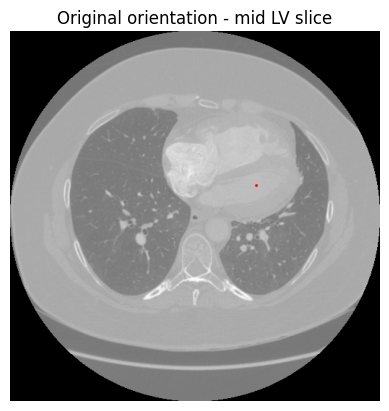

z_mid (mm): -210.875


In [122]:
z_inds = np.where(lv_mask.any(axis=(1,2)))[0]
z_mid = int(np.mean(z_inds))

lv_cog_vox = np.mean(np.column_stack(np.where(lv_mask)),axis=0)  # Z,Y,X
lv_cog_mm_world = img.TransformIndexToPhysicalPoint((int(lv_cog_vox[2]), int(lv_cog_vox[1]), int(lv_cog_vox[0])))
print("LV COG (vox):", lv_cog_vox)
print("LV COG (mm):", lv_cog_mm_world)

img_np = sitk.GetArrayFromImage(img)

plt.imshow(img_np[int(lv_cog_vox[0])], cmap="gray")
plt.scatter([lv_cog_vox[2]], [lv_cog_vox[1]], c="r", s=1)
plt.title("Original orientation - mid LV slice")
plt.axis("off")
plt.show()

# what is the real world coordinate of the center of gravity of the LV blood pool + myocardium?
z_mid_mm = img.TransformIndexToPhysicalPoint((0,0,z_mid))[2]
print("z_mid (mm):", z_mid_mm)


In [123]:
def mask_to_physical_points(mask, img):
    idx = np.column_stack(np.where(mask))  # Z,Y,X
    pts = np.array([
        img.TransformIndexToPhysicalPoint((int(x), int(y), int(z)))
        for z,y,x in idx
    ])
    return pts


In [124]:
lv_pts = mask_to_physical_points(lv_mask, img)
rv_pts = mask_to_physical_points(rv_mask, img)
la_pts = mask_to_physical_points(la_mask, img)

In [125]:
pca = PCA(n_components=3)
pca.fit(lv_pts)
z_hat = pca.components_[0]
z_hat /= np.linalg.norm(z_hat)


In [126]:
cog_lv = lv_pts.mean(axis=0)
cog_la = la_pts.mean(axis=0)
cog_rv = rv_pts.mean(axis=0)


In [127]:
if np.dot(z_hat, cog_la - cog_lv) < 0:
    z_hat = -z_hat


In [128]:
lv_to_rv = cog_rv - cog_lv
x_hat = lv_to_rv - np.dot(lv_to_rv, z_hat) * z_hat
x_hat /= np.linalg.norm(x_hat)

if np.dot(x_hat, np.array([1,0,0])) < 0:
    x_hat = -x_hat


In [129]:
y_hat = np.cross(z_hat, x_hat)
y_hat /= np.linalg.norm(y_hat)

# re-orthogonalise
x_hat = np.cross(y_hat, z_hat)


In [130]:
R = np.vstack([x_hat, y_hat, z_hat])

A_world_to_cardiac = np.eye(4)
A_world_to_cardiac[:3,:3] = R
A_world_to_cardiac[:3, 3] = -R @ cog_lv


In [131]:
A_cardiac_to_world = np.linalg.inv(A_world_to_cardiac)


In [132]:
size = img.GetSize()  # X,Y,Z

# let's limit it to the cardiac region
cariac_indices = np.column_stack(np.where(cardiac_mask))  # Z,Y,X
max_cardiac_corners = cariac_indices.max(axis=0)
min_cardiac_corners = cariac_indices.min(axis=0)

cardiac_corners = np.array([
    [min_cardiac_corners[2], min_cardiac_corners[1], min_cardiac_corners[0]],
    [max_cardiac_corners[2], min_cardiac_corners[1], min_cardiac_corners[0]],
    [min_cardiac_corners[2], max_cardiac_corners[1], min_cardiac_corners[0]],
    [min_cardiac_corners[2], min_cardiac_corners[1], max_cardiac_corners[0]],
    [max_cardiac_corners[2], max_cardiac_corners[1], min_cardiac_corners[0]],
    [max_cardiac_corners[2], min_cardiac_corners[1], max_cardiac_corners[0]],
    [min_cardiac_corners[2], max_cardiac_corners[1], max_cardiac_corners[0]],
    [max_cardiac_corners[2], max_cardiac_corners[1], max_cardiac_corners[0]],
])


# corners = np.array([
#     [0,0,0], [size[0],0,0], [0,size[1],0], [0,0,size[2]],
#     [size[0],size[1],0], [size[0],0,size[2]],
#     [0,size[1],size[2]], [size[0],size[1],size[2]]
# ])

corners_phys = np.array([
    img.TransformIndexToPhysicalPoint((int(c[0]), int(c[1]), int(c[2])))
    for c in cardiac_corners
])

corners_cardiac = (A_world_to_cardiac[:3,:3] @ corners_phys.T).T + A_world_to_cardiac[:3,3]

min_c = corners_cardiac.min(axis=0)
max_c = corners_cardiac.max(axis=0)


In [133]:
out_spacing = img.GetSpacing()
extent = max_c - min_c
out_size = np.ceil(extent / out_spacing).astype(int)

out_origin = min_c
out_direction = np.eye(3).ravel()


In [150]:
tx = sitk.AffineTransform(3)
tx.SetMatrix(A_cardiac_to_world[:3,:3].ravel())
tx.SetTranslation(A_cardiac_to_world[:3,3])

resampler = sitk.ResampleImageFilter()
resampler.SetSize(out_size.tolist())
resampler.SetOutputSpacing(out_spacing)
resampler.SetOutputOrigin(out_origin.tolist())
resampler.SetOutputDirection(out_direction)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetTransform(tx)
resampler.SetDefaultPixelValue(0)

img_sa = resampler.Execute(img)
resampler.SetInterpolator(sitk.sitkNearestNeighbor)
lbl_sa = resampler.Execute(remapped_lbl_img)


In [140]:
def calculate_midpoint(points):
    """Calculate the midpoint of a curve (e.g., septum)."""

    if len(points) < 3:
        raise ValueError("Insufficient points to calculate midpoint.")

    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

    # Find the index closest to half the total arc length
    idx_mid = np.argmin(np.abs(cumulative_distances - cumulative_distances[-1] / 2))
    return points[idx_mid]


In [141]:
def calculate_angle(p1, p2, p3, return_degrees=True):
    """
    Calculate the angle between three points in 2D/3D space.

    Parameters:
        p1, p2, p3: Arrays or lists representing the coordinates of the points.
        return_degrees: Boolean, if True returns angle in degrees, else in radians.

    Returns:
        Angle in degrees (default) or radians.
    """
    # Vectors from p2 to p1 and p2 to p3
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)

    # Dot product and magnitudes
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    # Calculate cosine and ensure numerical stability
    cosine_angle = np.clip(dot_product / (magnitude_v1 * magnitude_v2), -1.0, 1.0)
    angle_rad = np.arccos(cosine_angle)

    # Return angle in desired units
    if return_degrees:
        return np.degrees(angle_rad)
    return angle_rad

In [142]:
from scipy.spatial import distance
def order_contour_points(points, threshold=3):
    """
    Orders contour points into a single connected sequence based on proximity.

    Parameters:
        points (np.ndarray): Array of contour points (N x 2).
        threshold (float): Distance threshold to identify disconnections.

    Returns:
        np.ndarray: Ordered contour points as a single continuous array.
    """
    if len(points) <= 2:
        return points  # Nothing to sort for 2 or fewer points

    # Step 1: Identify jumps in contour points based on distance
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    jump_indices = np.where(distances > threshold)[0] + 1
    jump_indices = np.insert(jump_indices, 0, 0)
    jump_indices = np.append(jump_indices, len(points))

    # Split points into disconnected segments
    segments = [points[jump_indices[i]:jump_indices[i+1]] for i in range(len(jump_indices) - 1)]

    # Step 2: Iteratively merge segments into a single connected component
    while len(segments) > 1:
        # Calculate pairwise distances between segment edges
        distances_to_merge = []
        first_segment_edges = [segments[0][0], segments[0][-1]]
        for i in range(1, len(segments)):
            other_segment_edges = [segments[i][0], segments[i][-1]]
            distances_to_merge.append(distance.cdist(first_segment_edges, other_segment_edges))

        # Find the closest segment to merge
        distances_to_merge = np.array(distances_to_merge)
        min_idx = np.unravel_index(np.argmin(distances_to_merge), distances_to_merge.shape)
        min_distance = distances_to_merge[min_idx]

        if min_distance < threshold:
            # Determine merging order
            first_segment = segments[0]
            if min_idx[1] == 0:
                first_segment = first_segment[::-1]  # Reverse first segment

            second_segment = segments[min_idx[0] + 1]
            if min_idx[2] != 0:
                second_segment = second_segment[::-1]  # Reverse second segment

            # Merge segments
            merged_segment = np.concatenate((first_segment, second_segment), axis=0)
            segments.append(merged_segment)

            # Remove merged segments from the list
            del segments[min_idx[0] + 1]
            del segments[0]
        else:
            # Keep the largest segment if no further merging is possible
            segment_lengths = [len(seg) for seg in segments]
            segments = [segments[np.argmax(segment_lengths)]]

    return segments[0]

In [143]:
from scipy.ndimage import center_of_mass
import cv2
def extract_septum(endo, epi, rv):
    """Extract the septum region and compute related metrics."""
    # Extract epicardial contour points
    contours, _ = cv2.findContours(cv2.inRange(epi, 1, 1), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    epi_points = contours[0][:, 0, :]

    # Find the septum by intersecting LV epicardium with RV
    septum_points = []
    dilation_step = 1
    max_dilation_steps = 100  # Limit to prevent infinite loop

    while len(septum_points) == 0:
        # Check if we have a potential infinite loop
        if dilation_step > max_dilation_steps:
            raise ValueError(
                f"Unable to find an intersection between LV epicardium and RV after {max_dilation_steps} dilation steps."
            )

        # Dilate the RV mask until it intersects with the LV epicardium. Normally, this is fulfilled after just one iteration.
        rv_dilated = cv2.dilate(rv, np.ones((3, 3), dtype=np.uint8), iterations=dilation_step)
        dilation_step += 1
        for y, x in epi_points:
            if rv_dilated[x, y] == 1:
                septum_points.append(np.array([y, x]))

    # Order septum points
    septum_points = np.array(septum_points)
    ordered_septum = order_contour_points(septum_points)

    # Calculate key points of the septum
    mid_septum = calculate_midpoint(ordered_septum)
    septum_edge_1 = ordered_septum[0]
    septum_edge_2 = ordered_septum[-1]

    # Calculate the center of the LV cavity
    center_y, center_x = center_of_mass(endo)
    lv_center = np.round(np.array([center_x, center_y])).astype(int)

    # Calculate the septum angle
    angle_1 = calculate_angle(septum_edge_1, mid_septum, lv_center, return_degrees=True)
    angle_2 = calculate_angle(septum_edge_2, mid_septum, lv_center, return_degrees=True)
    total_septum_angle = angle_1 + angle_2

    return {
        "septum_angle": total_septum_angle,
        "septum_points": ordered_septum,
        "mid_septum": mid_septum,
        "septum_edge_1": septum_edge_1,
        "septum_edge_2": septum_edge_2,
        "lv_center": lv_center
    }


LV COG in cardiac space (mm): [-0.7041594   0.45707109 -0.05767237]
LV COG in SA index space (Z,Y,X): (146, 122, 127)
Short-axis stack shape (Z,Y,X): (310, 251, 229)
mid slice index: 127
LV width (mm): 32.52
RV width (mm): 47.70
RV/LV width ratio: 1.47


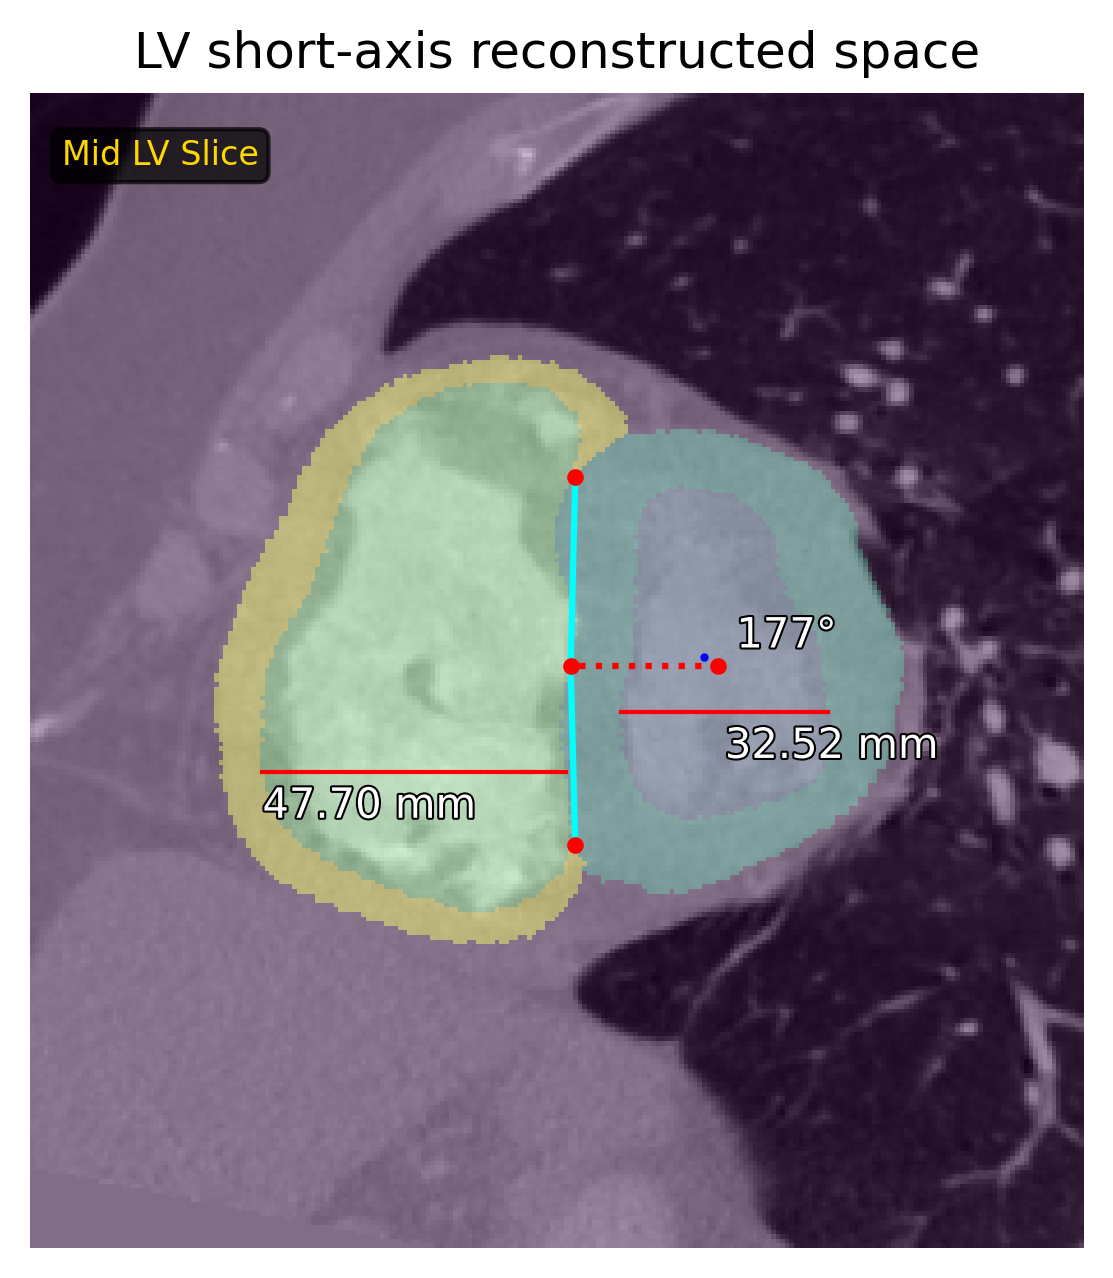

In [179]:
import matplotlib.patheffects as pe
img_sa_np = sitk.GetArrayFromImage(img_sa)
lbl_sa_np = sitk.GetArrayFromImage(lbl_sa)

# z_mid_sa = img_sa_np.shape[0] // 2
lv_cog_mm_cardiac = (A_world_to_cardiac @ np.array(lv_cog_mm_world + ( 1.0,)))[:3]
print("LV COG in cardiac space (mm):", lv_cog_mm_cardiac)
point = img_sa.TransformPhysicalPointToIndex((lv_cog_mm_cardiac))
print("LV COG in SA index space (Z,Y,X):", point)
z_mid_sa = int(point[2]) # should this be point[0] or point[2]?

print("Short-axis stack shape (Z,Y,X):", img_sa_np.shape)
print(f"mid slice index: {z_mid_sa}")

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300)

ax.imshow(img_sa_np[z_mid_sa], cmap="gray")
ax.imshow(lbl_sa_np[z_mid_sa], cmap="viridis", alpha=0.3)
z, y, x = point[2], point[1], point[0]
ax.scatter([x], [y], c="b", s=1)
ax.set_title("LV short-axis reconstructed space")
ax.axis("off")

lv_endo_mask = (lbl_sa_np[z_mid_sa] == LV_BP)
lv_epi_mask = (lbl_sa_np[z_mid_sa] == LV_MYO) | (lbl_sa_np[z_mid_sa] == LV_BP)
rv_endo_mask = (lbl_sa_np[z_mid_sa] == RV_BP)


sep_data = extract_septum(lv_endo_mask.astype(np.uint8), lv_epi_mask.astype(np.uint8), rv_endo_mask.astype(np.uint8))
sep_angle = sep_data['septum_angle']
lv_center = sep_data['lv_center']
mid_septum = sep_data['mid_septum']
septum_edge_1 = sep_data['septum_edge_1']
septum_edge_2 = sep_data['septum_edge_2']

# ang_ls.append(sep_angle)

ax.plot([septum_edge_1[0], mid_septum[0], septum_edge_2[0]], [septum_edge_1[1], mid_septum[1], septum_edge_2[1]], 'aqua')
ax.plot([lv_center[0], mid_septum[0]], [lv_center[1], mid_septum[1]], ':r', marker='o', markersize=3)
ax.plot(septum_edge_1[0], septum_edge_1[1], color='red', marker='o', markersize=3)
ax.plot(septum_edge_2[0], septum_edge_2[1], color='red', marker='o', markersize=3)

txt = ax.text(sep_data["lv_center"][0]+4, sep_data["lv_center"][1]-4, f'{int(np.round(sep_angle))}°', fontsize=10, color='w')
txt.set_path_effects([pe.withStroke(linewidth=1, foreground='k')])
description = 'Mid LV Slice'
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black", alpha=0.7)
ax.text(0.03, 0.96, f'{description}', color='gold', transform=ax.transAxes,
        fontsize=8, ha='left', va='top', bbox=bbox_props)


y_max_lv = np.argmax([
    (np.where(lv_endo_mask[y])[0].max() - np.where(lv_endo_mask[y])[0].min())
    if np.any(lv_endo_mask[y]) else 0
    for y in range(lv_endo_mask.shape[0])
])

xs_lv = np.where(lv_endo_mask[y_max_lv])[0]

y_max_rv = np.argmax([
    (np.where(rv_endo_mask[y])[0].max() - np.where(rv_endo_mask[y])[0].min())
    if np.any(rv_endo_mask[y]) else 0
    for y in range(rv_endo_mask.shape[0])
])

xs_rv = np.where(rv_endo_mask[y_max_rv])[0]

lv_min = img_sa.TransformIndexToPhysicalPoint((int(xs_lv.min()), int(y_max_lv), int(z_mid_sa)))[0]
lv_max = img_sa.TransformIndexToPhysicalPoint((int(xs_lv.max()), int(y_max_lv), int(z_mid_sa)))[0]
rv_min = img_sa.TransformIndexToPhysicalPoint((int(xs_rv.min()), int(y_max_rv), int(z_mid_sa)))[0]
rv_max = img_sa.TransformIndexToPhysicalPoint((int(xs_rv.max()), int(y_max_rv), int(z_mid_sa)))[0]

lv_width_mm = lv_max - lv_min
rv_width_mm = rv_max - rv_min
rv_lv_ratio = rv_width_mm / lv_width_mm

print(f"LV width (mm): {lv_width_mm:.2f}")
print(f"RV width (mm): {rv_width_mm:.2f}")
print(f"RV/LV width ratio: {rv_lv_ratio:.2f}")
mid_lv = xs_lv.min() + ((xs_lv.max() - xs_lv.min()) / 2.0)
mid_rv = xs_rv.min() + ((xs_rv.max() - xs_rv.min()) / 2.0)

txt = ax.text(mid_lv, y_max_lv + 10, f'{lv_width_mm:.2f} mm', fontsize=10, color='w')
txt.set_path_effects([pe.withStroke(linewidth=1, foreground='k')])
txt = ax.text(xs_rv.min(), y_max_rv + 10, f'{rv_width_mm:.2f} mm', fontsize=10, color='w')
txt.set_path_effects([pe.withStroke(linewidth=1, foreground='k')])
ax.plot([xs_lv.min(), xs_lv.max()], [y_max_lv, y_max_lv], 'r', linewidth=1)
ax.plot([xs_rv.min(), xs_rv.max()], [y_max_rv, y_max_rv], 'r', linewidth=1)
ax.axis("off")
plt.show()

